# LSTM For Predictive Maintenance

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score

from torch import nn
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

In [2]:
# Disable TQDM output
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [3]:
# Alternate to TQDM progress bar using alive_progress
from alive_progress import alive_bar

### Loading Dataset

In [4]:
dataset_train=pd.read_csv('data/PM_train.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names
print('Shape of Train dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Train dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
dataset_test=pd.read_csv('data/PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns=col_names
#dataset_test.head()
print('Shape of Test dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Test dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Loadind Truth table

In [6]:
pm_truth=pd.read_csv('data/PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns=['more']
pm_truth['id']=pm_truth.index+1
pm_truth.head()

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [7]:
# generate column max for test data
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [8]:
# run to failure
pm_truth['rtf']=pm_truth['more']+rul['max']
pm_truth.head()

,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [9]:
pm_truth.drop('more', axis=1, inplace=True)
dataset_test=dataset_test.merge(pm_truth,on=['id'],how='left')
dataset_test['ttf']=dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)
dataset_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [10]:
dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max)-dataset_train['cycle']
dataset_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [11]:
df_train=dataset_train.copy()
df_test=dataset_test.copy()
period=30
df_train['label_bc'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test['label_bc'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [12]:
features_col_name=['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name='label_bc'

## Feature Scaling

In [13]:
sc=MinMaxScaler()
df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
df_test[features_col_name]=sc.transform(df_test[features_col_name])

## Function to reshape dataset as required by LSTM

In [14]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [15]:
# timestamp or window size
seq_length=50
seq_cols=features_col_name

In [16]:
# generate X_train
X_train=np.concatenate(list(list(gen_sequence(df_train[df_train['id']==id], seq_length, seq_cols)) for id in df_train['id'].unique()))
print(X_train.shape)
# generate y_train
y_train=np.concatenate(list(list(gen_label(df_train[df_train['id']==id], 50, seq_cols,'label_bc')) for id in df_train['id'].unique()))
print(y_train.shape)

(20531, 50, 24)
(20531,)


In [17]:
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(df_test[df_test['id']==id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)
# generate y_test
y_test=np.concatenate(list(list(gen_label(df_test[df_test['id']==id], 50, seq_cols,'label_bc')) for id in df_test['id'].unique()))
print(y_test.shape)

(12996, 50, 24)
(12996,)


## LSTM Network

The source is [here](https://www.kaggle.com/code/omershect/learning-pytorch-lstm-deep-learning-with-m5-data/notebook).

In [18]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [19]:
class LSTMV2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTMV2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
        out = self.sig(out)
       
        return out

In [20]:
num_epochs = 100
learning_rate = 1e-3
input_size = 24
hidden_size = 100
num_layers = 1
num_classes = 1

In [21]:
#####Init the Model #######################
lstm = LSTMV2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

/home/adm.akram/anaconda3/envs/pytorch-mfp/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTMV2(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(24, 100, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [22]:
##### Set Criterion Optimzer and scheduler ####################
#criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression?
criterion = torch.nn.BCELoss().to(device)    # Binary cross entropy
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [23]:
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)

X_test_tensor = torch.tensor(X_test).float().to(device)
y_test_tensor = torch.tensor(y_test).long().to(device)

trainX = Variable(X_train_tensor)
trainY = Variable(y_train_tensor)

testX = Variable(X_test_tensor)
testY = Variable(y_test_tensor)

Visualize the distribution of the training and test set dsitribution of the classes. 

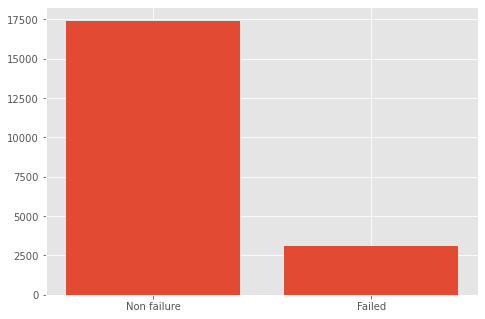

In [24]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xaxis = ['Non failure', 'Failed']
yaxis = [len(y_train_tensor)-sum(y_train_tensor),sum(y_train_tensor)]
ax.bar(xaxis,yaxis)
plt.show()

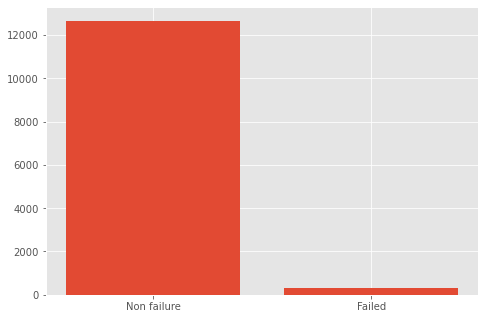

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xaxis = ['Non failure', 'Failed']
yaxis = [len(y_test_tensor)-sum(y_test_tensor),sum(y_test_tensor)]
ax.bar(xaxis,yaxis)
plt.show()

In [26]:
# function to predict accuracy
def get_accuracy(pred,label):
    pred = torch.round(pred.squeeze())
    return (torch.sum(pred == label.squeeze()).item() / len(label))

In [53]:
for epoch in range(num_epochs): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device).float())
    
    loss.backward()
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device).float())
    scheduler.step(vall_loss)

    acc = get_accuracy(outputs, trainY)
    acc_ = get_accuracy(valid, testY)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f, Train accuracy: %1.5f, Validation accuracy: %1.5f" %(epoch, loss.cpu().item(),vall_loss.cpu().item(), acc, acc_))

/home/adm.akram/anaconda3/envs/pytorch-mfp/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([20531])) that is different to the input size (torch.Size([20531, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/adm.akram/anaconda3/envs/pytorch-mfp/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([12996])) that is different to the input size (torch.Size([12996, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0, loss: 0.20069 valid loss:  0.03986, Train accuracy: 0.94598, Validation accuracy: 0.98800
Epoch: 50, loss: 0.18509 valid loss:  0.03038, Train accuracy: 0.95051, Validation accuracy: 0.98892


In [28]:
torch.save(lstm, "weights/v2.pt")

/home/adm.akram/anaconda3/envs/pytorch-mfp/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTMV2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adm.akram/anaconda3/envs/pytorch-mfp/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adm.akram/anaconda3/envs/pytorch-mfp/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adm.akram/anaconda3/envs/pytorch-mfp/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won'

Load pretrained model

In [29]:
model_ = torch.load('weights/v2.pt')

In [30]:
model_.eval()
valid = model_(testX.to(device))
valid_lbls = torch.round(valid.squeeze())
acc = get_accuracy(valid, testY)
cm = confusion_matrix(y_test, valid_lbls.cpu().detach())

print('Accuracy of model on test data: ', acc)
print('Confusion Matrix: \n',cm)

Accuracy of model on test data:  0.9880732533087103
Confusion Matrix: 
 [[12633    31]
 [  124   208]]


### Probability of Machine failure

In [31]:
def prob_failure(model, machine_id):
    machine_df=df_test[df_test.id==machine_id]
    machine_test=gen_sequence(machine_df,seq_length,seq_cols)
    machine_test_tensor = torch.tensor(machine_test).float().to(device)
    m_pred = model(machine_test_tensor)
    failure_prob = sum(m_pred*100) / len(m_pred)
    return failure_prob.to('cpu').detach().item()

In [32]:
machine_id=16
print('Probability that machine', machine_id ,'will fail within 30 days: ',prob_failure(model_, machine_id))

Probability that machine 16 will fail within 30 days:  0.48855751752853394


#### Evaluation with a Confusion Matrix.

For this example:

A false positive is “Unnecessary Maintenance.” When your model predicts failure and is not going to fail, you incur unnecessary maintenance costs. A true positive is “Timely and Appropriate Maintenance.” When your model predicts failure, and it is going to fail, you incur timely and appropriate maintenance costs. A false negative is “Machine Runs to Failure.” When your model does not predict failure and fails, you incur costs associated with running your machine to failure.

For this use case, this means that a false positive costs $1,500. A false negative costs $30,000. A true positive costs $7,500. A true negative has no cost because no action is taken.
|                       | True non failure               | True failure                |
|-----------------------|--------------------------------|-----------------------------|
| Predicted non failure |  No action: 0$                 | Unpredicted failure: $30000 |
| Predicted failure     | Unnecessary maintenance: $1500 | Timely maintenance: $7500

A confusion matrix is a cross-tabulation between the actual binary failure/non-failure variable vs the binary prediction of failure/non-failure. Remember that we have two actual failure values.

In [33]:
# Total cost of maintenance:
cost_matrix = [[0, 30000],[1500, 7500]]
total_individual_cost = cm * cost_matrix
total_cost = sum(sum(total_individual_cost))

total_cost_without_pm = sum(y_test) * cost_matrix[0][1]

cost_extra = (cm[1][0])*cost_matrix[1][0] + (cm[0][1])*cost_matrix[0][1]

print("The total maintenance cost in dollars is: ", total_cost)
print("The total maintenance cost (without predictive maintenance) in dollars is: ", total_cost_without_pm)
print("The cost matrix is as follows: \n", total_individual_cost)
print("The amount saved in dollars using predictive maintenance is: ", total_cost_without_pm - total_cost)
print("The cost incurred due to unnecessary maintenance and unpredicted failure despite predictive maintenance is", cost_extra)
print("The effective amount saved with predictive maintenance is", total_cost_without_pm - total_cost - cost_extra)

The total maintenance cost in dollars is:  2676000
The total maintenance cost (without predictive maintenance) in dollars is:  9960000.0
The cost matrix is as follows: 
 [[      0  930000]
 [ 186000 1560000]]
The amount saved in dollars using predictive maintenance is:  7284000.0
The cost incurred due to unnecessary maintenance and unpredicted failure despite predictive maintenance is 1116000
The effective amount saved with predictive maintenance is 6168000.0


### Improving the predictive maintenance using SafeML

Now we will utilize SafeML (library), to improve predictive maintenance.

Todo:
* Apply K means clustering on the training and test set
* Obtain performance vs SDD curve
  * Fine tuning required
  * Current problem: Model performance is too good. 
* Obtain the StaDRe and StaDRo

Todo for final improvement:
* On test set, apply StaDRo, ignore the ML-output for the instances which are predicted to be not robust against
* Check the reduction/increase in maintenance cost based on that

In [34]:
# Generic utilities
import sys
import math

path_safeml = "/data3/Akram/Projects/safeml/"
sys.path.insert(0, path_safeml)

from safeml.core.ecdf_distance_measures import WassersteinDistance

Unable to import Tensorflow.


/data3/Akram/Projects/safeml/safeml/core/ecdf_distance_measures.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Now, let us check the performance vs SDD. The Statistical Distance based Dissimilarity (SDD) gives an indication of how far the two sets being compared are with each other. Let us use a sample of size 200 from the test set.

In [62]:
X_train_wd = X_train_tensor[:200].to('cpu').numpy()

In [63]:
acc_all = torch.tensor([])
wd_all = torch.tensor([])
batches = 200
steps = int(math.ceil(X_test_tensor.shape[0] / 200))

for i in range(steps):
    x_chunck = X_test_tensor[i*batches:i*batches+batches]
    y_chunck = y_test_tensor[i*batches:i*batches+batches]
    
    valid_step = model_(Variable(x_chunck).to(device))
    valid_step_lbls = torch.round(valid_step.squeeze())
    acc = get_accuracy(valid_step, Variable(y_chunck))

    WassDist = WassersteinDistance()

    _, wd = WassDist.measure_metric_p_value_gpu(X_train_wd, x_chunck.to('cpu').numpy())

    acc_all = torch.cat((acc_all, torch.tensor([acc])), 0)
    wd_all = torch.cat((wd_all, torch.tensor([wd.mean().item()])), 0)


  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [64]:
acc_all.mean(), wd_all.mean()

(tensor(0.9881), tensor(0.0391))

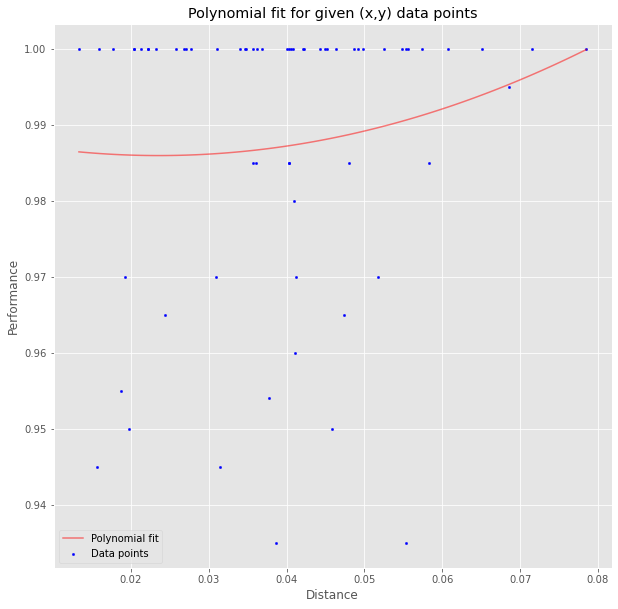

In [65]:
# UNCOMMENT THE BELOW LINES FOR VISUAL REPRESENTATIONS OF SDD vs ACCURACY PLOT
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize
fit_polynomial_curve_to_data_and_visualize(wd_all, acc_all, 2)

Now, let us compute the SDD for each input along with its performance using trained ML (either correctly classified or not). For this, let us use the entire training set and compute the distance along with each of the test specimen. It can further be tested against a subset. Maybe around a set of 200.

This is however a very costly computationally expensive process. An alternative is to focus on False-Positive, and False negative results of the model. By considering True positive, and true negatives from the training set as baseline. First, obtain the distance between the training set positive and negative classes.  

In [39]:
def split_failed_not_failed(data, lbls):
    try:
        assert len(data) == len(lbls)
    except:
        print("INPUT ERROR: Length mismatch. Data and lables have inconsistent length.")
        return None
    failed_idxs = (lbls == 1).nonzero()
    failed_idxs = failed_idxs.squeeze(1)
    y_nfailed = lbls[failed_idxs]
    x_nfailed = data[failed_idxs]

    notfailed_idxs = (lbls == 0).nonzero()
    notfailed_idxs = notfailed_idxs.squeeze(1)
    y_failed = lbls[notfailed_idxs]
    x_failed = data[notfailed_idxs]
    
    return x_nfailed, y_nfailed, x_failed, y_failed

In [40]:
torch.__version__

'1.3.1'

In [41]:
tnx, tny, tfx, tfy = split_failed_not_failed(X_train_tensor, y_train_tensor)
WassDist = WassersteinDistance()
pval, wd = WassDist.measure_metric_p_value_gpu(tnx.to('cpu').numpy(), tfx.to('cpu').numpy())
pval, wd_all_n = WassDist.measure_metric_p_value_gpu(X_train_tensor.to('cpu').numpy(), tnx.to('cpu').numpy()) 
pval, wd_all_f = WassDist.measure_metric_p_value_gpu(X_train_tensor.to('cpu').numpy(), tfx.to('cpu').numpy()) 

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [42]:
print(wd.mean().item(), sum(wd).item())
print(wd_all_n.mean().item(), sum(wd_all_n).item())
print(wd_all_f.mean().item(), sum(wd_all_f).item())

0.11064010941975057 132.768128088802
0.09392808260122805 112.71369639218062
0.016690375816718863 20.028450495086002


In [43]:
vnx, vny, vfx, vfy = split_failed_not_failed(X_test_tensor, y_test_tensor)
WassDist = WassersteinDistance()
pvalv, wdv = WassDist.measure_metric_p_value_gpu(vnx.to('cpu').numpy(), vfx.to('cpu').numpy())
pval, wd_all_vn = WassDist.measure_metric_p_value_gpu(X_train_tensor.to('cpu').numpy(), vnx.to('cpu').numpy()) 
pval, wd_all_vf = WassDist.measure_metric_p_value_gpu(X_train_tensor.to('cpu').numpy(), vfx.to('cpu').numpy()) 

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [44]:
print(wdv.mean().item(), sum(wdv).item())
print(wd_all_vn.mean().item(), sum(wd_all_vn).item())
print(wd_all_vf.mean().item(), sum(wd_all_vf).item())

0.11387800747554809 136.65360566167428
0.07372337203693814 88.46804430212634
0.040407138249857144 48.48856472570778


In [45]:
valid_step_each = model_(X_test_tensor)
valid_step_lbl_each = torch.round(valid_step_each.squeeze())
valid_step_lbl_each = valid_step_lbl_each.detach().to('cpu').numpy()

In [46]:
valid_step_tensor = torch.tensor(valid_step_lbl_each).to(device)
valid_step_tensor.shape

torch.Size([12996])

In [47]:
rnx, rny, rfx, rfy = split_failed_not_failed(X_test_tensor, valid_step_tensor)
WassDist = WassersteinDistance()
pvalr, wdr = WassDist.measure_metric_p_value_gpu(rnx.to('cpu').numpy(), rfx.to('cpu').numpy())
pval, wd_all_rn = WassDist.measure_metric_p_value_gpu(X_train_tensor.to('cpu').numpy(), rnx.to('cpu').numpy()) 
pval, wd_all_rf = WassDist.measure_metric_p_value_gpu(X_train_tensor.to('cpu').numpy(), rfx.to('cpu').numpy()) 

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [48]:
print(wdr.mean().item(), sum(wdr).item())
print(wd_all_rn.mean().item(), sum(wd_all_rn).item())
print(wd_all_rf.mean().item(), sum(wd_all_rf).item())

0.12264688267674885 147.17625564831607
0.08311841375628984 99.74209409235425
0.03975289894829957 47.70347758284906


In [49]:
# def get_sdd(train_set, image):
#     image = image[None, :, :]
#     wasserstein_distance = WassersteinDistance()

#     # Calculate Wasserstein Distance
#     pval, WD = wasserstein_distance.measure_metric_p_value_gpu(train_set, kll.to('cpu').numpy())
#     #WD = [WD[pval <= 0.05].mean().cpu().numpy(), sum(WD[pval <= 0.05]).cpu().numpy()]

#     return(WD)

In [50]:
# from torch.multiprocessing import Pool, set_start_method
# import pickle

# try:
#     set_start_method('spawn')
# except RuntimeError:
#     print("ERROR: Could not set spawn start method.")
#     pass

# PROC_PER_GPU = 10
# sdd_all = []

In [51]:
#print(len(IM), len(LB), len(XA))
# pool = Pool(processes=PROC_PER_GPU)
# constants = [X_train_wd, X_test_tensor]

# result = [pool.apply_async(get_sdd, constants)]
# sdd = [r.get() for r in result]

# for i in sdd:
#     sdd_all.append(float(i[0].to('cpu').numpy()))


# with open('sdd_final', 'wb') as fp:
#     pickle.dump(sdd_all, fp)

In [52]:
# wd_each_all = torch.tensor([])

# with alive_bar(X_test_tensor.shape[0]) as bar:
#     for kll in X_test_tensor:
#         kll = kll[None, :, :]
#         WassDist = WassersteinDistance()
#         _, wd = WassDist.measure_metric_p_value_gpu(X_train_wd, kll.to('cpu').numpy()) #for full, use X_train_tensor.to('cpu').numpy()

#         wd_each_all = torch.cat((wd_each_all, torch.tensor([wd.mean().item()])), 0)
#         bar()
    
# wd_each_all.shape